# Kaggle Titanic Competition Data Analysis in Python

First of all, modules that will be used further along are imported. Pandas is used to facilitate csv reading and overall data wrangling, numpy is imported for certain functions used further along and seaborn is used for plots.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting of seaborn plotting style
sns.set(style = 'darkgrid')

Data is imported from csv files

In [47]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

### Exploratory Data Analysis

Simple analysis of the data is carried out first to see how the data is structured, what issues we may face further along the line and find preliminary relations.

First analyses are on the variable names to check the consistency between variable names, differences between datasets, etc.

In [18]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


The summary information of the training data ser shows missing data (null values) for 'Age', 'Cabin' and 'Embarked' variables. This is due to the number of non-null values being less than the number of entries (891).

In [48]:
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


The same summary for the test dataset shows missing data for 'Age', 'Fare' and 'Cabin' variables.

There seems to be consistency with the column names of the different datasets. However, to be certain, a consistency check is carried to compared the above results.

In [49]:
print(train_data.columns.difference(test_data.columns))

Index(['Survived'], dtype='object')


The 'Survived' variable is not present in the test dataset. This must be considered when merging the two datasets.

Because the 'Survived' variable is not present in the test dataset, it will be set as NaN. This is necessary to create a dataset with all the data (training and test), as any further transformation must be carried out equally on any data used. For this reason it is easier to created a single dataset.

In [50]:
# setting missing variable in test dataset to NaN
test_data['Survived'] = np.nan

# complete dataset with all data
all_data = train_data.append(test_data, ignore_index=True)

Now that an initial analysis of the datatypes, structure of data and basic exploratory analyses have been carried out, a relational-based analysis will be carried out. The relation to be analysed is the output ('Survived' variable) against its multiple predictors (other covariates).

The first analysis will be on survival rates for men and women separately. This analysis is based on the "women and children" first code of conduct. Based on this code of conduct, it would be expected that men have poorer survival rates when compared to 
women.

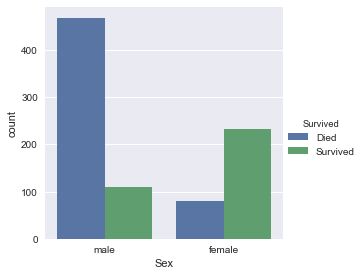

In [51]:
survived_map = {1.0: 'Survived', 0.0: 'Died'}

all_data['Survived'] = all_data['Survived'].map(survived_map)

sns.factorplot(x = 'Sex', hue = 'Survived', data = all_data, kind = 'count')

plt.show()

As can be seen from the above plot, survival rates for men are much lower than for women.

Next, based on 